In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_annotations(file_path):
    """Membaca file JSON dan mengambil label anotasi."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    if isinstance(data, dict) and "annotations" in data:
        data = data["annotations"]
    else:
        raise ValueError("Format JSON tidak sesuai, tidak ditemukan daftar anotasi.")
    
    annotations = []
    for entry in data:
        if isinstance(entry, list) and len(entry) > 1 and isinstance(entry[1], dict) and "entities" in entry[1]:
            annotations.append(entry[1]["entities"])
    
    return annotations

In [3]:
def merge_annotations(file_annotator1, file_annotator2, output_file):
    # Load data anotasi
    with open(file_annotator1, 'r', encoding='utf-8') as f:
        data1 = json.load(f)
    
    with open(file_annotator2, 'r', encoding='utf-8') as f:
        data2 = json.load(f)
    
    # Pastikan format data sesuai yang diharapkan
    if "classes" not in data1 or "annotations" not in data1:
        raise ValueError("Format file anotator 1 tidak sesuai")
    if "classes" not in data2 or "annotations" not in data2:
        raise ValueError("Format file anotator 2 tidak sesuai")
    
    # Mendapatkan anotasi mentah
    raw_annotations1 = data1["annotations"]
    raw_annotations2 = data2["annotations"]
    
    min_articles = min(len(raw_annotations1), len(raw_annotations2))
    print(f"Jumlah artikel yang akan diproses: {min_articles}")
    
    # Buat struktur untuk anotasi gabungan
    merged_results = {
        "classes": data1["classes"],
        "annotations": []
    }
    
    # Proses setiap artikel
    for i in range(min_articles):
        if i < len(raw_annotations1) and i < len(raw_annotations2):
            article1 = raw_annotations1[i]
            article2 = raw_annotations2[i]
            
            # Pastikan format artikel valid
            if not (isinstance(article1, list) and len(article1) >= 2 and isinstance(article2, list) and len(article2) >= 2):
                print(f"Format artikel tidak valid untuk indeks {i}")
                continue
            
            # Ambil teks dan entitas dari kedua anotator
            text1 = article1[0]
            entities1 = article1[1].get("entities", []) if isinstance(article1[1], dict) else []
            
            text2 = article2[0]
            entities2 = article2[1].get("entities", []) if isinstance(article2[1], dict) else []
            
            # Verifikasi teks sama antara kedua anotator
            if text1 != text2:
                print(f"Peringatan: Teks artikel berbeda untuk indeks {i}")
            
            # Konversi entitas ke format yang mudah dibandingkan
            entity_set1 = {tuple(entity) for entity in entities1}
            entity_set2 = {tuple(entity) for entity in entities2}
            
            # Ambil entitas yang disepakati oleh kedua anotator
            common_entities = entity_set1.intersection(entity_set2)
            
            # Buat hasil gabungan jika ada entitas yang cocok
            if common_entities:
                merged_annotations = []
                for entity in sorted(common_entities):
                    start, end, label = entity
                    merged_annotations.append([start, end, label])
                
                # Tambahkan ke hasil akhir dengan teks lengkap
                merged_results["annotations"].append([text1, {"entities": merged_annotations}])
    
    # Simpan hasil anotasi gabungan
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(merged_results, f, indent=4, ensure_ascii=False)
    
    print(f"Hasil anotasi gabungan disimpan di {output_file}")
    return merged_results

In [4]:
files = [
    {'file_annotator1': 'cleaned/annotated/bengkalis_kab_part1_ammar.json', 'file_annotator2': 'cleaned/annotated/bengkalis_kab_part1_ilyas.json', 'output_file': 'cleaned/annotated/merged/bengkalis_kab_part1.json', 'conf_matrix_title': 'Confusion Matrix - Bengkalis Bagian 1'},
    {'file_annotator1': 'cleaned/annotated/bengkalis_kab_part2_ammar.json', 'file_annotator2': 'cleaned/annotated/bengkalis_kab_part2_chris.json', 'output_file': 'cleaned/annotated/merged/bengkalis_kab_part2.json', 'conf_matrix_title': 'Confusion Matrix - Bengkalis Bagian 2'},
    {'file_annotator1': 'cleaned/annotated/bengkalis_kab_part3_chris.json', 'file_annotator2': 'cleaned/annotated/bengkalis_kab_part3_edo.json', 'output_file': 'cleaned/annotated/merged/bengkalis_kab_part3.json', 'conf_matrix_title': 'Confusion Matrix - Bengkalis Bagian 3'},
    {'file_annotator1': 'cleaned/annotated/bengkalis_kab_part4_edo.json', 'file_annotator2': 'cleaned/annotated/bengkalis_kab_part4_ilyas.json', 'output_file': 'cleaned/annotated/merged/bengkalis_kab_part4.json', 'conf_matrix_title': 'Confusion Matrix - Bengkalis Bagian 4'},
    {'file_annotator1': 'cleaned/annotated/blitar_kab_ammar.json', 'file_annotator2': 'cleaned/annotated/blitar_kab_chris.json', 'output_file': 'cleaned/annotated/merged/blitar_kab.json', 'conf_matrix_title': 'Confusion Matrix - Blitar'},
    {'file_annotator1': 'cleaned/annotated/bombana_kab_ammar.json', 'file_annotator2': 'cleaned/annotated/bombana_kab_edo.json', 'output_file': 'cleaned/annotated/merged/bombana_kab.json', 'conf_matrix_title': 'Confusion Matrix - Bombana'},
    {'file_annotator1': 'cleaned/annotated/depok_kota_part1_edo.json', 'file_annotator2': 'cleaned/annotated/depok_kota_part1_ilyas.json', 'output_file': 'cleaned/annotated/merged/depok_kota_part1.json', 'conf_matrix_title': 'Confusion Matrix - Depok Bagian 1'},
    {'file_annotator1': 'cleaned/annotated/depok_kota_part2_ammar.json', 'file_annotator2': 'cleaned/annotated/depok_kota_part2_ilyas.json', 'output_file': 'cleaned/annotated/merged/depok_kota_part2.json', 'conf_matrix_title': 'Confusion Matrix - Depok Bagian 2'},
    {'file_annotator1': 'cleaned/annotated/depok_kota_part3_ammar.json', 'file_annotator2': 'cleaned/annotated/depok_kota_part3_chris.json', 'output_file': 'cleaned/annotated/merged/depok_kota_part3.json', 'conf_matrix_title': 'Confusion Matrix - Depok Bagian 3'},
    {'file_annotator1': 'cleaned/annotated/depok_kota_part4_chris.json', 'file_annotator2': 'cleaned/annotated/depok_kota_part4_edo.json', 'output_file': 'cleaned/annotated/merged/depok_kota_part4.json', 'conf_matrix_title': 'Confusion Matrix - Depok Bagian 4'},
    {'file_annotator1': 'cleaned/annotated/jatim_part1_ammar.json', 'file_annotator2': 'cleaned/annotated/jatim_part1_ilyas.json', 'output_file': 'cleaned/annotated/merged/jatim_part1.json', 'conf_matrix_title': 'Confusion Matrix - Jawa Timur Bagian 1'},
    {'file_annotator1': 'cleaned/annotated/jatim_part2_ammar.json', 'file_annotator2': 'cleaned/annotated/jatim_part2_chris.json', 'output_file': 'cleaned/annotated/merged/jatim_part2.json', 'conf_matrix_title': 'Confusion Matrix - Jawa Timur Bagian 2'},
    {'file_annotator1': 'cleaned/annotated/jatim_part3_chris.json', 'file_annotator2': 'cleaned/annotated/jatim_part3_edo.json', 'output_file': 'cleaned/annotated/merged/jatim_part3.json', 'conf_matrix_title': 'Confusion Matrix - Jawa Timur Bagian 3'},
    {'file_annotator1': 'cleaned/annotated/jatim_part4_edo.json', 'file_annotator2': 'cleaned/annotated/jatim_part4_ilyas.json', 'output_file': 'cleaned/annotated/merged/jatim_part4.json', 'conf_matrix_title': 'Confusion Matrix - Jawa Timur Bagian 4'},
    {'file_annotator1': 'cleaned/annotated/kab_rejanglebong_chris.json', 'file_annotator2': 'cleaned/annotated/kab_rejanglebong_ilyas.json', 'output_file': 'cleaned/annotated/merged/kab_rejanglebong.json', 'conf_matrix_title': 'Confusion Matrix - Rejang Lebong'},
    {'file_annotator1': 'cleaned/annotated/kab_deliserdang_chris.json', 'file_annotator2': 'cleaned/annotated/kab_deliserdang_ilyas.json', 'output_file': 'cleaned/annotated/merged/kab_deliserdang.json', 'conf_matrix_title': 'Confusion Matrix - Deli Serdang'},
    {'file_annotator1': 'cleaned/annotated/kalimantan_utara_part1_chris.json', 'file_annotator2': 'cleaned/annotated/kalimantan_utara_part1_ilyas.json', 'output_file': 'cleaned/annotated/merged/kalimantan_utara_part1.json', 'conf_matrix_title': 'Confusion Matrix - Kalimantan Utara Bagian 1'},
    {'file_annotator1': 'cleaned/annotated/kalimantan_utara_part2_ammar.json', 'file_annotator2': 'cleaned/annotated/kalimantan_utara_part2_edo.json', 'output_file': 'cleaned/annotated/merged/kalimantan_utara_part2.json', 'conf_matrix_title': 'Confusion Matrix - Kalimantan Utara Bagian 2'},
    {'file_annotator1': 'cleaned/annotated/kalimantan_utara_part3_chris.json', 'file_annotator2': 'cleaned/annotated/kalimantan_utara_part3_ilyas.json', 'output_file': 'cleaned/annotated/merged/kalimantan_utara_part3.json', 'conf_matrix_title': 'Confusion Matrix - Kalimantan Utara Bagian 3'},
    {'file_annotator1': 'cleaned/annotated/kalimantan_utara_part4_ammar.json', 'file_annotator2': 'cleaned/annotated/kalimantan_utara_part4_edo.json', 'output_file': 'cleaned/annotated/merged/kalimantan_utara_part4.json', 'conf_matrix_title': 'Confusion Matrix - Kalimantan Utara Bagian 4'},
    {'file_annotator1': 'cleaned/annotated/kalimantanbarat_ammar.json', 'file_annotator2': 'cleaned/annotated/kalimantanbarat_ilyas.json', 'output_file': 'cleaned/annotated/merged/kalimantanbarat.json', 'conf_matrix_title': 'Confusion Matrix - Kalimantan Barat'},
    {'file_annotator1': 'cleaned/annotated/kota_baubau_ammar.json', 'file_annotator2': 'cleaned/annotated/kota_baubau_ilyas.json', 'output_file': 'cleaned/annotated/merged/kota_baubau.json', 'conf_matrix_title': 'Confusion Matrix - Baubau'},
    {'file_annotator1': 'cleaned/annotated/kota_mahakamulu_ammar.json', 'file_annotator2': 'cleaned/annotated/kota_mahakamulu_ilyas.json', 'output_file': 'cleaned/annotated/merged/kota_mahakamulu.json', 'conf_matrix_title': 'Confusion Matrix - Mahakam Ulu'},
    {'file_annotator1': 'cleaned/annotated/kota_malang_ammar.json', 'file_annotator2': 'cleaned/annotated/kota_malang_edo.json', 'output_file': 'cleaned/annotated/merged/kota_malang.json', 'conf_matrix_title': 'Confusion Matrix - Malang'},
    {'file_annotator1': 'cleaned/annotated/kota_salatiga_chris.json', 'file_annotator2': 'cleaned/annotated/kota_salatiga_ilyas.json', 'output_file': 'cleaned/annotated/merged/kota_salatiga.json', 'conf_matrix_title': 'Confusion Matrix - Salatiga'},
    {'file_annotator1': 'cleaned/annotated/lampungtengah_chris.json', 'file_annotator2': 'cleaned/annotated/lampungtengah_edo.json', 'output_file': 'cleaned/annotated/merged/lampungtengah.json', 'conf_matrix_title': 'Confusion Matrix - Lampung Tengah'},
    {'file_annotator1': 'cleaned/annotated/madiun_kota_edo.json', 'file_annotator2': 'cleaned/annotated/madiun_kota_ilyas.json', 'output_file': 'cleaned/annotated/merged/madiun_kota.json', 'conf_matrix_title': 'Confusion Matrix - Madiun'},
    {'file_annotator1': 'cleaned/annotated/ngada_kab_ammar.json', 'file_annotator2': 'cleaned/annotated/ngada_kab_chris.json', 'output_file': 'cleaned/annotated/merged/ngada_kab.json', 'conf_matrix_title': 'Confusion Matrix - Ngada'},
    {'file_annotator1': 'cleaned/annotated/ngawi_kab_edo.json', 'file_annotator2': 'cleaned/annotated/ngawi_kab_ilyas.json', 'output_file': 'cleaned/annotated/merged/ngawi_kab.json', 'conf_matrix_title': 'Confusion Matrix - Ngawi'},
    {'file_annotator1': 'cleaned/annotated/puncak_jaya_kab_ammar.json', 'file_annotator2': 'cleaned/annotated/puncak_jaya_kab_edo.json', 'output_file': 'cleaned/annotated/merged/puncak_jaya_kab.json', 'conf_matrix_title': 'Confusion Matrix - Puncak Jaya'},
    {'file_annotator1': 'cleaned/annotated/semarang_kota_chris.json', 'file_annotator2': 'cleaned/annotated/semarang_kota_edo.json', 'output_file': 'cleaned/annotated/merged/semarang_kota.json', 'conf_matrix_title': 'Confusion Matrix - Semarang'},
    {'file_annotator1': 'cleaned/annotated/sleman_kab_chris.json', 'file_annotator2': 'cleaned/annotated/sleman_kab_edo.json', 'output_file': 'cleaned/annotated/merged/sleman_kab.json', 'conf_matrix_title': 'Confusion Matrix - Sleman'},
]   

Jumlah artikel annotator 1: 518
Jumlah artikel annotator 2: 518
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        12                         9
Annotator 2: Not Labeled                     0                       497


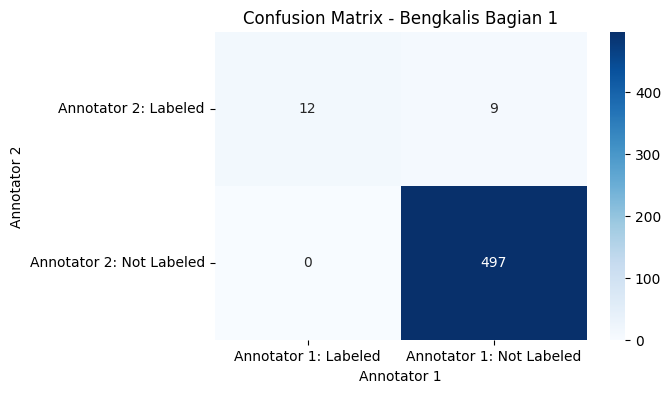

Cohen's Kappa Score: 0.7190
Interpretasi Kappa: Moderate
Jumlah artikel yang akan diproses: 518
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/bengkalis_kab_part1.json
Jumlah artikel annotator 1: 518
Jumlah artikel annotator 2: 518
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         2                         1
Annotator 2: Not Labeled                     1                       514


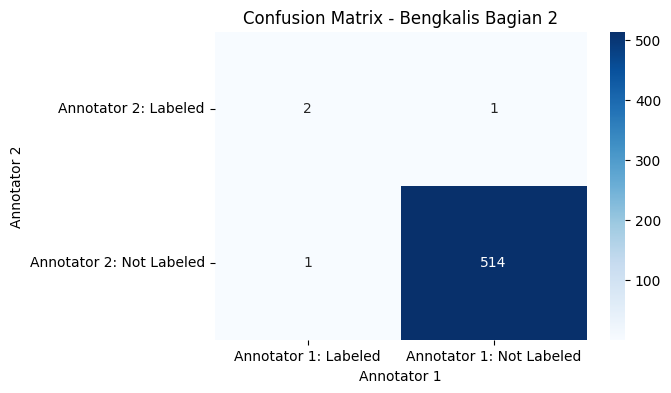

Cohen's Kappa Score: 0.6647
Interpretasi Kappa: Moderate
Jumlah artikel yang akan diproses: 518
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/bengkalis_kab_part2.json
Jumlah artikel annotator 1: 518
Jumlah artikel annotator 2: 518
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         7                         1
Annotator 2: Not Labeled                     0                       510


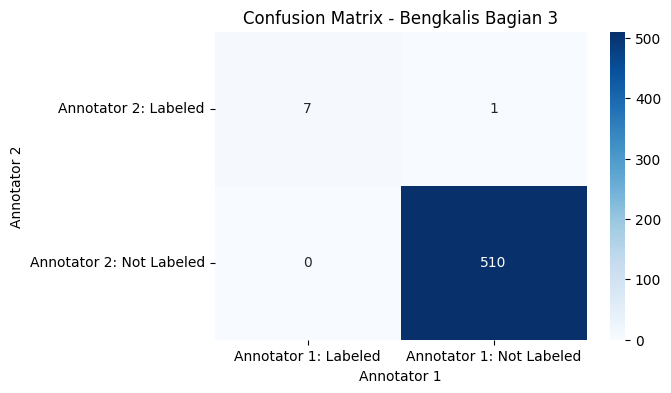

Cohen's Kappa Score: 0.9324
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 518
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/bengkalis_kab_part3.json
Jumlah artikel annotator 1: 517
Jumlah artikel annotator 2: 517
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         3                         0
Annotator 2: Not Labeled                     0                       514


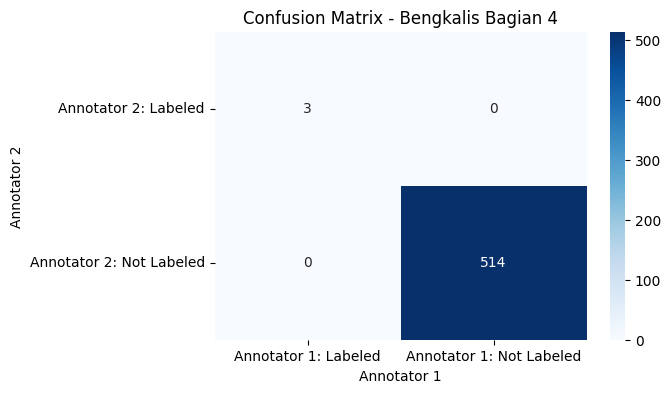

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 517
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/bengkalis_kab_part4.json
Jumlah artikel annotator 1: 707
Jumlah artikel annotator 2: 707
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         6                         0
Annotator 2: Not Labeled                     0                       701


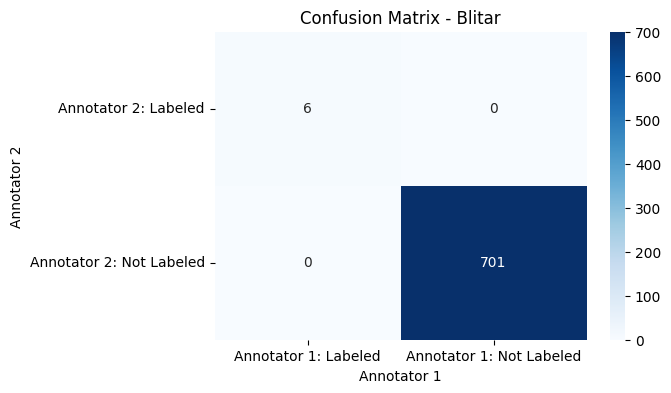

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 707
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/blitar_kab.json
Jumlah artikel annotator 1: 313
Jumlah artikel annotator 2: 314
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         7                         1
Annotator 2: Not Labeled                     0                       305


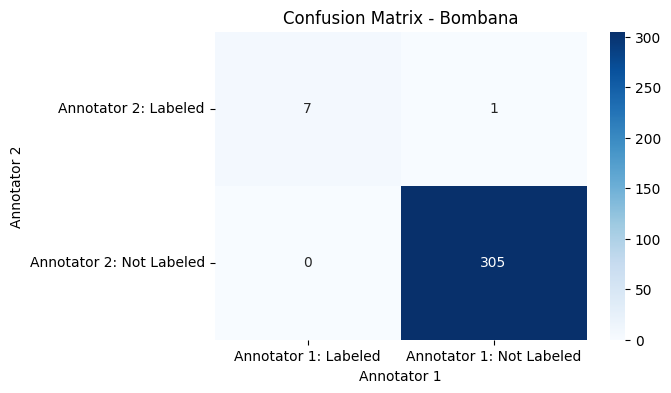

Cohen's Kappa Score: 0.9317
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 313
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/bombana_kab.json
Jumlah artikel annotator 1: 495
Jumlah artikel annotator 2: 495
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        11                         2
Annotator 2: Not Labeled                     2                       480


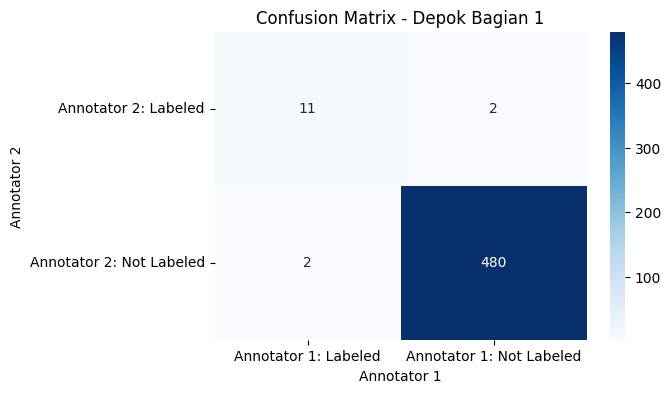

Cohen's Kappa Score: 0.8420
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 495
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/depok_kota_part1.json
Jumlah artikel annotator 1: 495
Jumlah artikel annotator 2: 495
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         5                         0
Annotator 2: Not Labeled                     1                       489


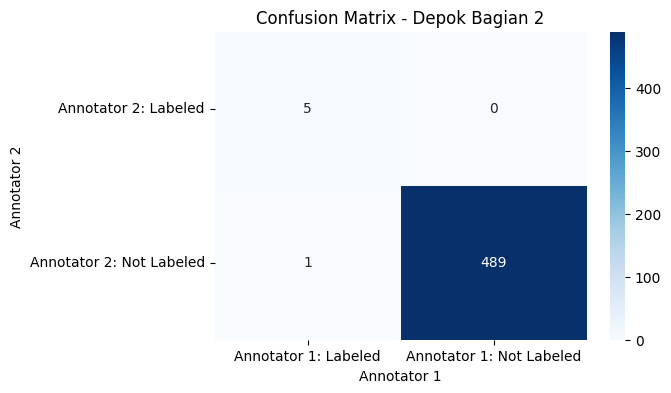

Cohen's Kappa Score: 0.9081
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 495
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/depok_kota_part2.json
Jumlah artikel annotator 1: 495
Jumlah artikel annotator 2: 495
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         1                         0
Annotator 2: Not Labeled                     0                       494


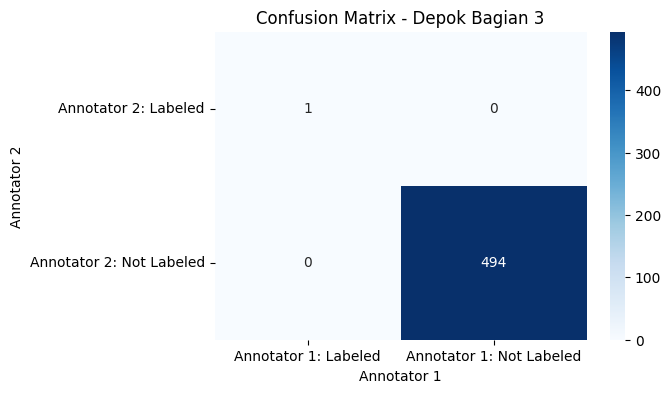

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 495
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/depok_kota_part3.json
Jumlah artikel annotator 1: 495
Jumlah artikel annotator 2: 495
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        14                         2
Annotator 2: Not Labeled                     2                       477


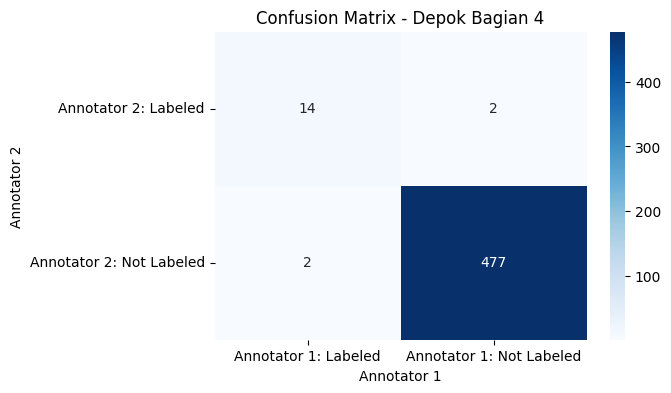

Cohen's Kappa Score: 0.8708
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 495
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/depok_kota_part4.json
Jumlah artikel annotator 1: 1306
Jumlah artikel annotator 2: 1306
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        46                        10
Annotator 2: Not Labeled                    11                      1239


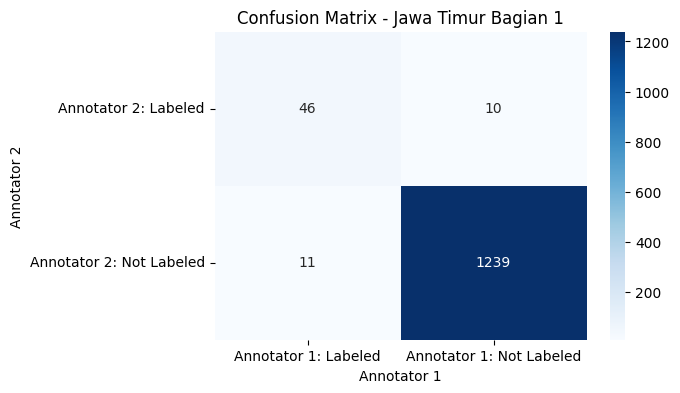

Cohen's Kappa Score: 0.8058
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 1306
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/jatim_part1.json
Jumlah artikel annotator 1: 1306
Jumlah artikel annotator 2: 1306
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        26                         1
Annotator 2: Not Labeled                     1                      1278


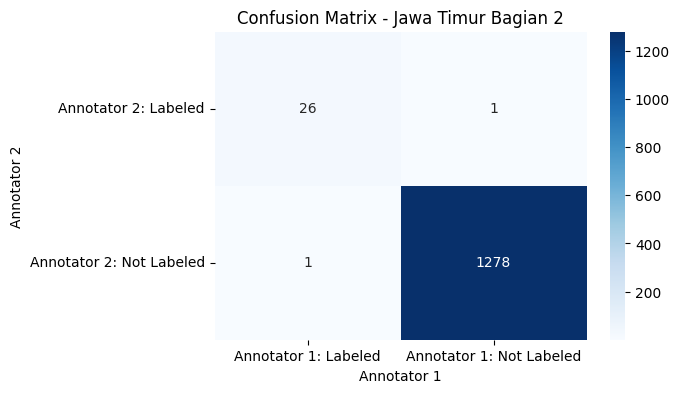

Cohen's Kappa Score: 0.9622
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1306
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/jatim_part2.json
Jumlah artikel annotator 1: 1306
Jumlah artikel annotator 2: 1307
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        17                         0
Annotator 2: Not Labeled                     4                      1285


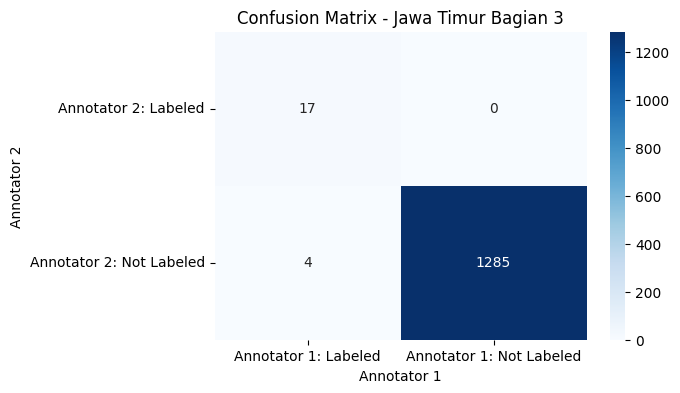

Cohen's Kappa Score: 0.8932
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 1306
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/jatim_part3.json
Jumlah artikel annotator 1: 1306
Jumlah artikel annotator 2: 1306
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        16                         1
Annotator 2: Not Labeled                     2                      1287


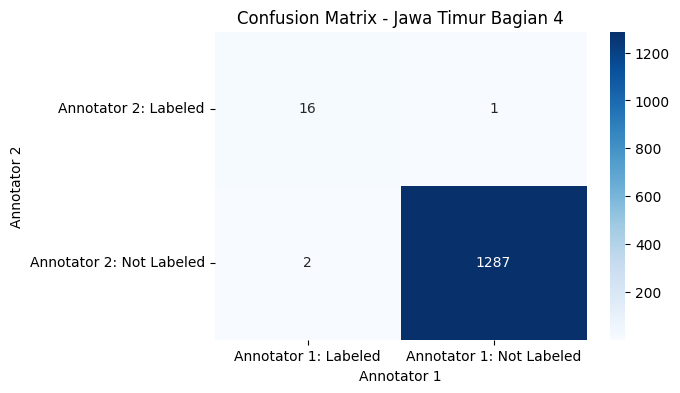

Cohen's Kappa Score: 0.9131
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1306
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/jatim_part4.json
Jumlah artikel annotator 1: 1091
Jumlah artikel annotator 2: 1091
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        28                         0
Annotator 2: Not Labeled                     0                      1063


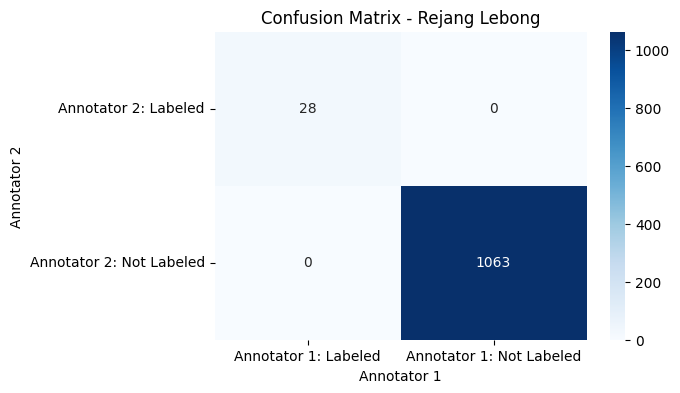

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1091
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kab_rejanglebong.json
Jumlah artikel annotator 1: 1580
Jumlah artikel annotator 2: 1580
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        40                         0
Annotator 2: Not Labeled                     0                      1540


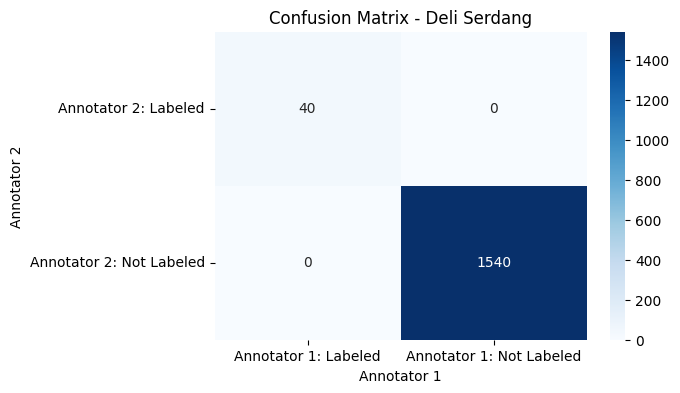

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1580
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kab_deliserdang.json
Jumlah artikel annotator 1: 506
Jumlah artikel annotator 2: 505
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        11                         2
Annotator 2: Not Labeled                     1                       491


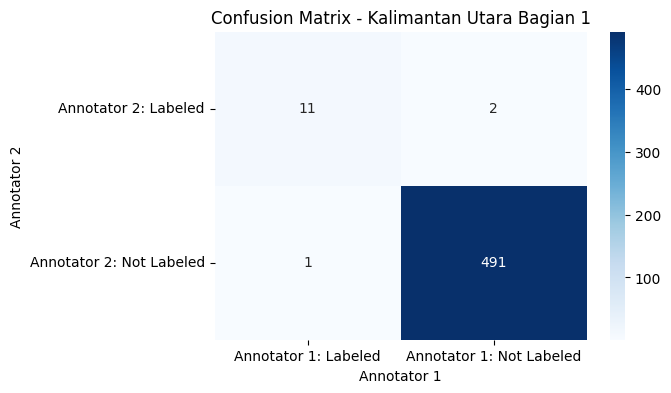

Cohen's Kappa Score: 0.8770
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 505
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kalimantan_utara_part1.json
Jumlah artikel annotator 1: 506
Jumlah artikel annotator 2: 505
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        12                         0
Annotator 2: Not Labeled                     0                       493


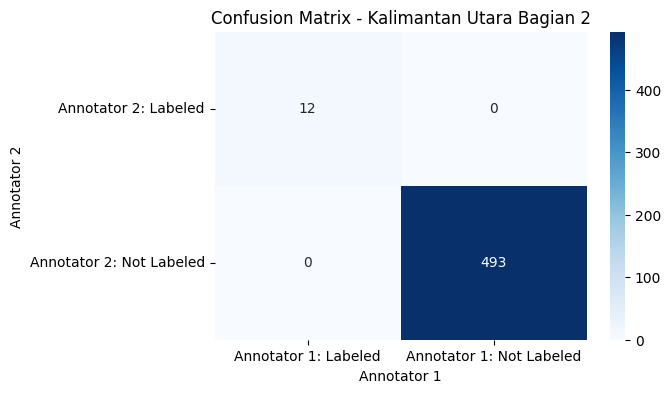

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 505
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kalimantan_utara_part2.json
Jumlah artikel annotator 1: 505
Jumlah artikel annotator 2: 506
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         6                         0
Annotator 2: Not Labeled                     1                       498


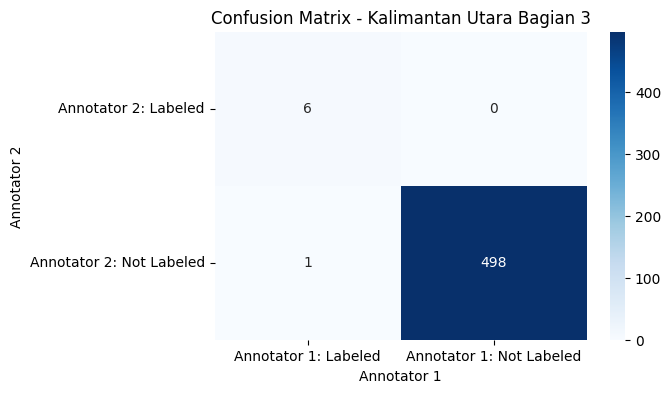

Cohen's Kappa Score: 0.9221
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 505
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kalimantan_utara_part3.json
Jumlah artikel annotator 1: 505
Jumlah artikel annotator 2: 505
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        10                         1
Annotator 2: Not Labeled                     0                       494


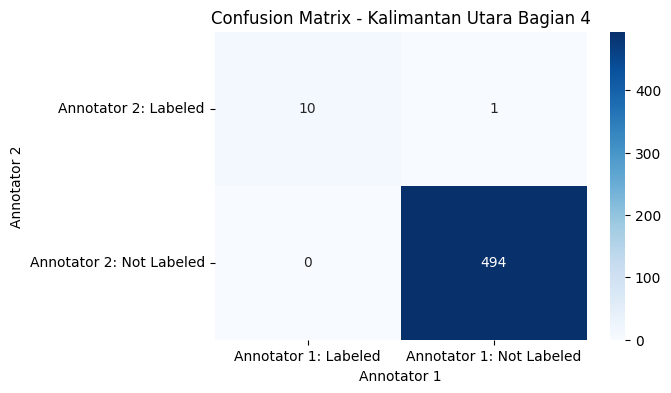

Cohen's Kappa Score: 0.9514
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 505
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kalimantan_utara_part4.json
Jumlah artikel annotator 1: 804
Jumlah artikel annotator 2: 804
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        16                         5
Annotator 2: Not Labeled                     1                       782


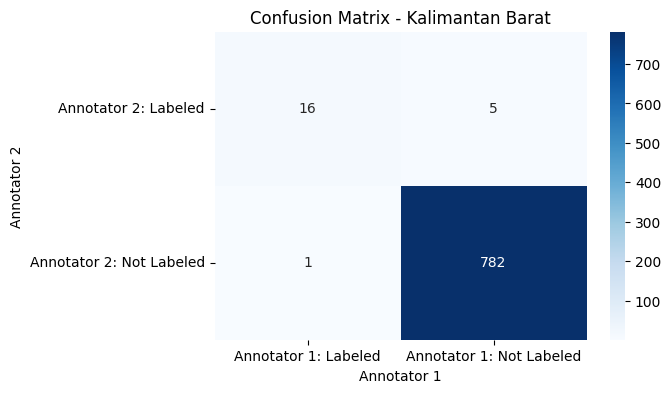

Cohen's Kappa Score: 0.8383
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 804
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kalimantanbarat.json
Jumlah artikel annotator 1: 102
Jumlah artikel annotator 2: 102
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         5                         0
Annotator 2: Not Labeled                     0                        97


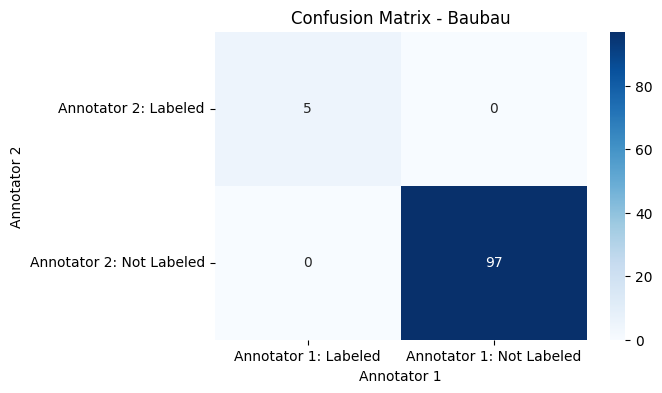

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 102
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kota_baubau.json
Jumlah artikel annotator 1: 1611
Jumlah artikel annotator 2: 1611
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        40                         5
Annotator 2: Not Labeled                     1                      1565


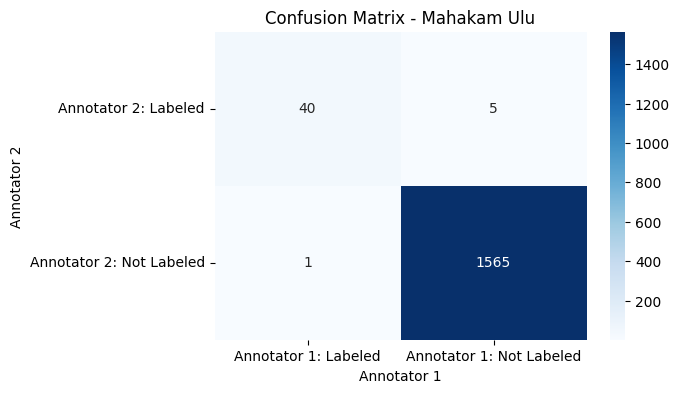

Cohen's Kappa Score: 0.9283
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1611
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kota_mahakamulu.json
Jumlah artikel annotator 1: 995
Jumlah artikel annotator 2: 995
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        12                         0
Annotator 2: Not Labeled                     1                       982


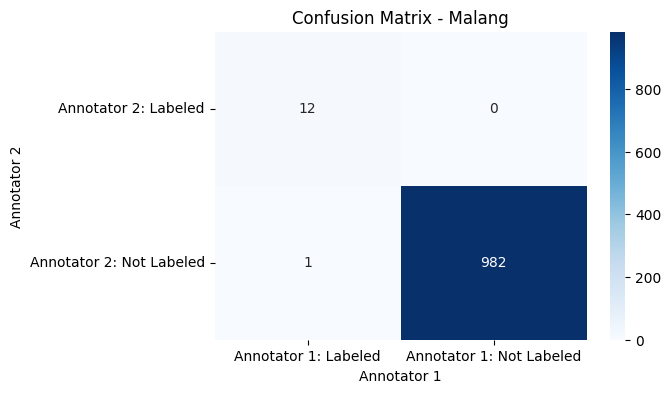

Cohen's Kappa Score: 0.9595
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 995
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kota_malang.json
Jumlah artikel annotator 1: 1056
Jumlah artikel annotator 2: 1056
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        17                         0
Annotator 2: Not Labeled                     1                      1038


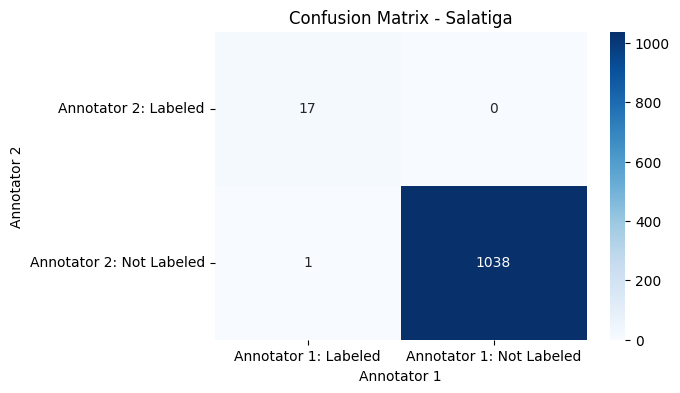

Cohen's Kappa Score: 0.9709
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1056
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/kota_salatiga.json
Jumlah artikel annotator 1: 1065
Jumlah artikel annotator 2: 1065
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        27                         0
Annotator 2: Not Labeled                     0                      1038


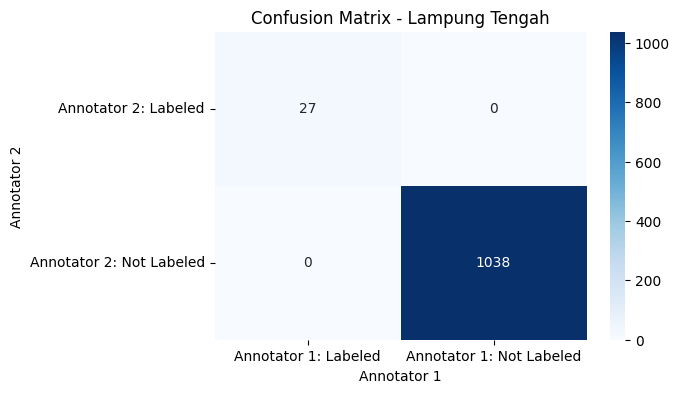

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1065
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/lampungtengah.json
Jumlah artikel annotator 1: 1271
Jumlah artikel annotator 2: 1271
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         7                         0
Annotator 2: Not Labeled                     0                      1264


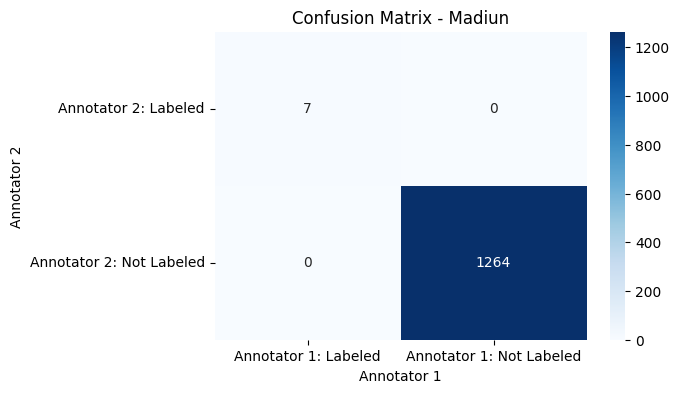

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1271
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/madiun_kota.json
Jumlah artikel annotator 1: 154
Jumlah artikel annotator 2: 154
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         1                         1
Annotator 2: Not Labeled                     0                       152


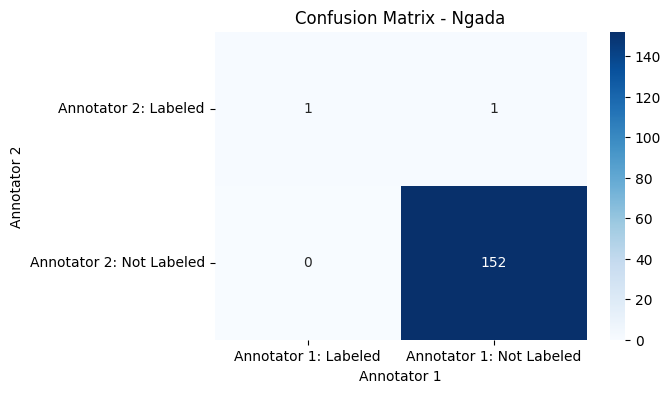

Cohen's Kappa Score: 0.6638
Interpretasi Kappa: Moderate
Jumlah artikel yang akan diproses: 154
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/ngada_kab.json
Jumlah artikel annotator 1: 1779
Jumlah artikel annotator 2: 1779
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        11                         3
Annotator 2: Not Labeled                     1                      1764


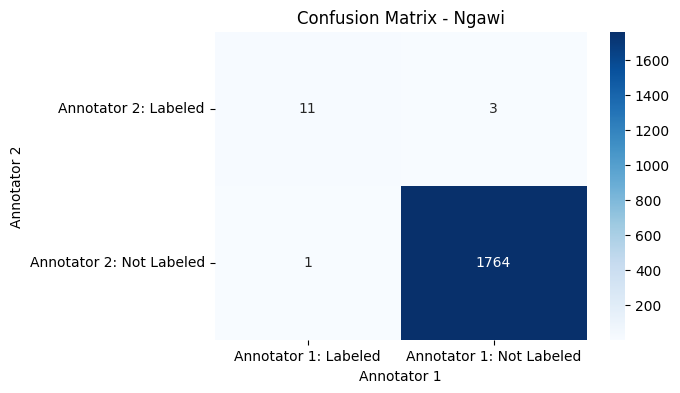

Cohen's Kappa Score: 0.8450
Interpretasi Kappa: Strong
Jumlah artikel yang akan diproses: 1779
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/ngawi_kab.json
Jumlah artikel annotator 1: 419
Jumlah artikel annotator 2: 419
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                         2                         1
Annotator 2: Not Labeled                     0                       416


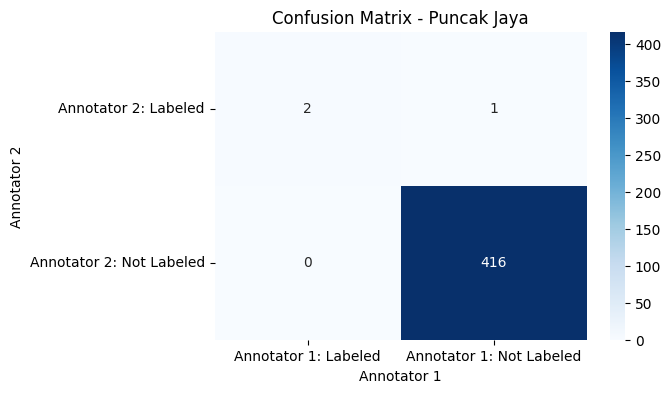

Cohen's Kappa Score: 0.7988
Interpretasi Kappa: Moderate
Jumlah artikel yang akan diproses: 419
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/puncak_jaya_kab.json
Jumlah artikel annotator 1: 1281
Jumlah artikel annotator 2: 1282
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        34                         1
Annotator 2: Not Labeled                     6                      1240


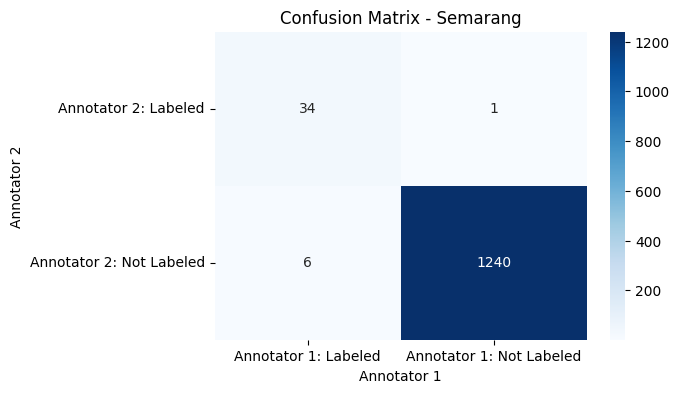

Cohen's Kappa Score: 0.9039
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1281
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/semarang_kota.json
Jumlah artikel annotator 1: 1052
Jumlah artikel annotator 2: 1052
Confusion Matrix:
                          Annotator 1: Labeled  Annotator 1: Not Labeled
Annotator 2: Labeled                        10                         0
Annotator 2: Not Labeled                     0                      1042


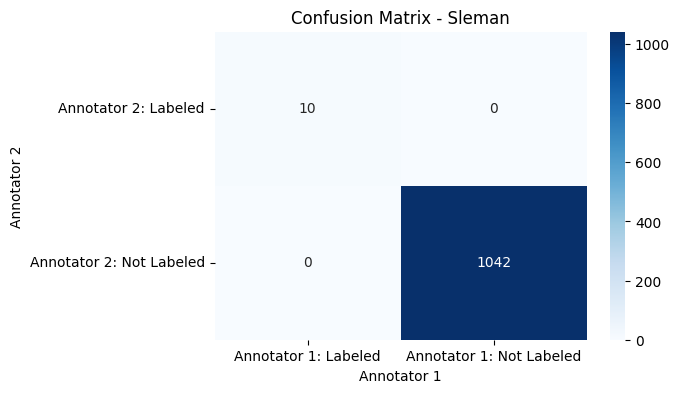

Cohen's Kappa Score: 1.0000
Interpretasi Kappa: Almost perfect
Jumlah artikel yang akan diproses: 1052
Hasil anotasi gabungan disimpan di cleaned/annotated/merged/sleman_kab.json


In [5]:
for file_pair in files:
    file_annotator1 = file_pair['file_annotator1']
    file_annotator2 = file_pair['file_annotator2']
    output_file = file_pair['output_file']
    conf_matrix_title = file_pair['conf_matrix_title']
    
    # Load data anotasi
    annotations1 = load_annotations(file_annotator1)
    annotations2 = load_annotations(file_annotator2)
    
    print(f"Jumlah artikel annotator 1: {len(annotations1)}")
    print(f"Jumlah artikel annotator 2: {len(annotations2)}")
    
    min_articles = min(len(annotations1), len(annotations2))
    
    # Buat kategori untuk confusion matrix
    A = B = C = D = 0
    
    for i in range(min_articles):
        entities1 = annotations1[i]
        entities2 = annotations2[i]
        
        if entities1 and entities2:
            A += 1
        elif entities2 and not entities1:
            B += 1
        elif entities1 and not entities2:
            C += 1
        else:
            D += 1
    
    # Tampilkan confusion matrix dengan label yang lebih deskriptif
    conf_matrix = np.array([[A, B], [C, D]])
    conf_matrix_df = pd.DataFrame(
        conf_matrix,
        index=["Annotator 2: Labeled", "Annotator 2: Not Labeled"],
        columns=["Annotator 1: Labeled", "Annotator 1: Not Labeled"]
    )
    
    print("Confusion Matrix:")
    print(conf_matrix_df)
    
    # Visualisasi confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Annotator 1: Labeled", "Annotator 1: Not Labeled"],
                yticklabels=["Annotator 2: Labeled", "Annotator 2: Not Labeled"])
    plt.title(conf_matrix_title)
    plt.xlabel("Annotator 1")
    plt.ylabel("Annotator 2")
    plt.show()
    
    # Hitung Observer Agreement (Po)
    P_o = (A + D) / min_articles
    
    # Hitung Expected Agreement (Pe)
    P_entitas = ((A + B) / min_articles) * ((A + C) / min_articles)
    P_none = ((C + D) / min_articles) * ((B + D) / min_articles)
    P_e = P_entitas + P_none
    
    # Hitung Cohen's Kappa
    if P_e != 1:
        kappa_score = (P_o - P_e) / (1 - P_e)
    else:
        kappa_score = 0
    
    print(f"Cohen's Kappa Score: {kappa_score:.4f}")
    
    # Interpretasi hasil
    if kappa_score <= 0.20:
        interpretation = "None"
    elif kappa_score < 0.40:
        interpretation = "Minimal"
    elif kappa_score < 0.60:
        interpretation = "Weak"
    elif kappa_score < 0.80:
        interpretation = "Moderate"
    elif kappa_score <= 0.90:
        interpretation = "Strong"
    else:
        interpretation = "Almost perfect"
    
    print(f"Interpretasi Kappa: {interpretation}")
    
   # Jika kappa > 0.6, simpan anotasi yang disepakati
    if kappa_score > 0.6:
        merge_annotations(file_annotator1,file_annotator2,output_file )